In [1]:


TRAINING_SET_SIZE = 5000



In [2]:


! pip3 install matplotlib
! pip3 install tensorflow-addons
! pip3 install pandas
! pip3 install pendulum
! pip3 install keras_tuner
import os
import pendulum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import keras_tuner as kt




     |████████████████████████████████| 11.3 MB 21.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 29.9 MB/s eta 0:00:01
     |████████████████████████████████| 890 kB 22.7 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 26.8 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 11.5 MB 19.7 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 155 kB 24.2 MB/s eta 0:00:01
     |████████████████████████████████| 489 kB 28.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 98 kB 10.7 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install -

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
from residualmlp.residual_mlp import ResidualMLP

In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 50
num_epochs = 100
image_size = 32  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 5
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [5]:


cifar = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar

y_train_ohe = tf.one_hot([i[0] for i in y_train], 10)
indexes_for_rows = tf.range(0, y_train.shape[0])
shuffled_indexes = tf.random.shuffle(indexes_for_rows)
selected_indexes = shuffled_indexes[:TRAINING_SET_SIZE]
selected_x_train = x_train[selected_indexes, :, :, :]
selected_y_train_ohe = y_train_ohe.numpy()[selected_indexes, :]



170508288/170498071 [==============================] - 8s 0us/step


2022-01-17 09:06:55.248576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-17 09:06:55.259862: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-17 09:06:55.260551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-17 09:06:55.262477: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-17 09:06:55.263087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

In [6]:


data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)



2022-01-17 09:06:57.081656: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [7]:


class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches



(-0.5, 31.5, 31.5, -0.5)

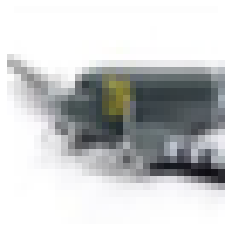

In [8]:


plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")



In [9]:
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")


Image size: 32 X 32
Patch size: 6 X 6
Patches per image: 25
Elements per patch: 108


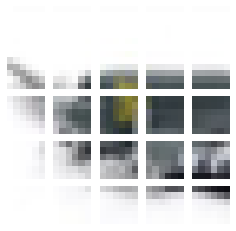

In [10]:


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")



In [11]:


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded



In [12]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [13]:
def create_vit_classifier(vit_base_model_input_shape = (32, 32, 3)):
    
    inputs = layers.Input(shape=vit_base_model_input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1) # x3 = residual_mlp
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    #representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    #features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    #logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    
    model = keras.Model(inputs=inputs, outputs=representation)
    return model

In [14]:


base_vit_model = create_vit_classifier()



In [15]:
base_vit_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 32, 32, 3)    7           input_1[0][0]                    
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 108)    0           data_augmentation[0][0]          
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 25, 64)       8576        patches_1[0][0]                  
______________________________________________________________________________________________

In [16]:


base_vit_model(x_train[:5])

<tf.Tensor: shape=(5, 1600), dtype=float32, numpy=
array([[ 2.3454142 , -0.4750308 , -0.742527  , ..., -0.14118469,
        -0.6517954 ,  1.7791226 ],
       [ 1.334048  , -0.2568164 , -0.5088399 , ..., -0.1422742 ,
        -1.1282926 ,  0.06327623],
       [-1.6194777 , -0.38929886,  0.07982185, ..., -0.02445328,
        -0.6952469 ,  0.844184  ],
       [ 1.8533131 , -0.17120257, -0.75661623, ..., -0.84780395,
        -2.5262234 ,  1.4657283 ],
       [-1.2375643 , -0.9151571 ,  0.7243939 , ..., -0.26934433,
        -2.4512022 ,  1.3618976 ]], dtype=float32)>

In [17]:


res_mlp = ResidualMLP(problem_type = 'classification', #
                      learning_rate = .0007, #
                      input_shape = (32, 32, 3), #(32,32,3), #
                      bw_images = False, #
                      base_model = base_vit_model, #
                      base_model_input_shape = (32, 32, 3),  # (600,600,3), #
                      flatten_after_base_model = False, #
                      blocks = [[7, 75, 8], [5, 75, 10]], #
                      residual_bypass_dense_layers = list(), #
                      b_norm_or_dropout_residual_bypass_layers = 'dropout', #
                      dropout_rate_for_bypass_layers = .7, #
                      inter_block_layers_per_block = [],
                      b_norm_or_dropout_last_layers = 'dropout', # | 'bnorm'
                      dropout_rate = .18, #
                      activation = tf.keras.activations.relu, #
                      final_dense_layers = [], #
                      number_of_classes = 10, # 1 if a regression problem
                      # final_activation = tf.keras.activations.softmax, #
                      #loss = tf.keras.losses.CategoricalCrossentropy(
                      #    from_logits=False)
                     )

In [18]:
tuner = kt.RandomSearch(
    res_mlp.build_auto_residual_mlp,
    objective='val_loss',
    max_trials=5)
tuner.search(selected_x_train, selected_y_train_ohe, epochs=20, validation_split=0.3)


Trial 6 Complete [00h 01m 55s]
val_loss: 2.0508553981781006

Best val_loss So Far: 2.0508553981781006
Total elapsed time: 00h 07m 33s
INFO:tensorflow:Oracle triggered exit


In [19]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
learning_rate (Float)
{'default': 7e-05, 'conditions': [], 'min_value': 7e-05, 'max_value': 0.7, 'step': None, 'sampling': 'log'}
blocks (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 

In [21]:
model = tuner.get_best_models()

All permutations:
      number_of_blocks  layers_per_block  neurons_per_block_layer  \
0                    1                 1                        1   
1                    1                 1                        1   
2                    1                 1                        1   
3                    1                 1                        1   
4                    1                 1                        1   
...                ...               ...                      ...   
2396                 7                 7                        7   
2397                 7                 7                        7   
2398                 7                 7                        7   
2399                 7                 7                        7   
2400                 7                 7                        7   

      neurons_per_block_layer_decay  
0                                 1  
1                                 2  
2                                 3  
3

In [24]:
model[0].save('test_model_from_first_successful_auto_run')

2022-01-17 09:21:06.522766: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: test_model_from_first_successful_auto_run/assets


INFO:tensorflow:Assets written to: test_model_from_first_successful_auto_run/assets
/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
